# Rhetorical and sentiment analysis

# Imports 

In [1]:
import simplejson
import numpy as np
from glob import glob
from bs4 import BeautifulSoup
from datetime import datetime
from os.path import basename, join
from pprint import pprint
import re
import pickle 
import cPickle
import pandas as pd

from pprint import pprint
from datetime import datetime
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep

from joblib import Parallel, delayed

import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt

import sys
sys.path.append("/root/sa/edu_dependency_parser/src")
from trees.parse_tree import ParseTree

import requests
import simplejson
import operator

from wordcloud import WordCloud

%matplotlib inline

In [2]:
import spacy
nlp = spacy.load('en')

# Aspect-based sentiment analysis flow - texual data summarization 

<img src="images/Rhetorical analysis - Flow croped.png">

# Exemplary Discourse Tree

<img src="images/Rhetorical Analysis example.png">

# Load parsed data 

In [81]:
data_path = '/datasets/sentiment/aspects/results-brexit/results/brexit-news-all/'

In [82]:
def load_serialized(f_path, f_name):
    with open(join(f_path, f_name)) as f:
        obj = cPickle.load(f)
    return obj

In [83]:
aspect_graph = load_serialized(data_path, 'aspects_graph') 

## Sentiment EDUs load

In [84]:
sent_edu = load_serialized(data_path, 'sentiment_filtered_edus')

In [85]:
len(sent_edu)

75073

In [86]:
sent_edu.items()[:3]

[(0,
  {'raw_text': u't students from the european union starting university courses in the uk this autumn will have their student loans funding honoured ,',
   'sentiment': array([1]),
   'source_document_id': 0,
   'tokens': [{'is_stop': False, 'lemma': u't', 'pos': u'NOUN', 'text': u't'},
    {'is_stop': False,
     'lemma': u'student',
     'pos': u'NOUN',
     'text': u'students'},
    {'is_stop': True, 'lemma': u'from', 'pos': u'ADP', 'text': u'from'},
    {'is_stop': True, 'lemma': u'the', 'pos': u'DET', 'text': u'the'},
    {'is_stop': False,
     'lemma': u'european',
     'pos': u'ADJ',
     'text': u'european'},
    {'is_stop': False, 'lemma': u'union', 'pos': u'NOUN', 'text': u'union'},
    {'is_stop': False, 'lemma': u'start', 'pos': u'VERB', 'text': u'starting'},
    {'is_stop': False,
     'lemma': u'university',
     'pos': u'NOUN',
     'text': u'university'},
    {'is_stop': False, 'lemma': u'course', 'pos': u'NOUN', 'text': u'courses'},
    {'is_stop': True, 'lemma':

## Aspects load 

In [87]:
aspect_edu = load_serialized(data_path, 'aspects_per_edu')

### Summarize sentiment per aspect

In [88]:
def graph_stats(graph):
    n_n = len(graph.nodes())
    n_e = len(graph.edges())
    print '#Nodes: {}'.format(n_n)
    print '#Edges: {}'.format(n_e)
    print 'Connections coverage: {}%'.format(( float(n_e) / (n_n * n_n ) * 100))

    degree_sequence=sorted(nx.degree(graph).values(),reverse=True) # degree sequence
    dmax=max(degree_sequence)

    print '-'*30
    print 'Highest degree of nodes'
    nd=sorted(aspect_graph.degree_iter(), key=itemgetter(1), reverse=True)
    df_nd = pd.DataFrame(nd, columns=['aspect', 'degree'])
    #     pprint([x for x in nd if len(x[0]) > 1]) # filter out aspect consists of one letter

    print '-'*30
    print 'Page Rank'
    pg = nx.pagerank(aspect_graph)
    df_pg = pd.DataFrame(pg.items(), columns=['aspect', 'pagerank'])
    # pgs = [(node, pagerank) for node, pagerank in pg.items()]
    #     pprint(pgs[:top_n])
    print '-'*30
    pprint('Unique Values of Page Rank: {}, unique nodes: {}'.format(len(set([pagerank for node, pagerank in pg.items()])), n_n))
    doc_asp_sent = []
    for doc_id, aspects in aspect_edu.iteritems():
        for aspect in aspects:
            doc_asp_sent.append((aspect, sent_edu[doc_id]['sentiment'][0]))

    df = pd.DataFrame()
    df['aspect'] = [x[0] for x in doc_asp_sent]
    df['sentiment'] = [x[1] for x in doc_asp_sent]

    df_mean = df.groupby('aspect').mean().reset_index().sort_values('sentiment', ascending=False)
    df_mean.columns = ['aspect', 'mean_sent']
    df_sum = df.groupby('aspect').sum().reset_index().sort_values('sentiment', ascending=False)
    df_sum.columns = ['aspect', 'sum_sent']

    df = pd.merge(df_mean, df_sum, on='aspect')
    df = pd.merge(df, df_pg, on='aspect')
    df = pd.merge(df, df_nd, on='aspect')

    df = df[[u'aspect', u'mean_sent', u'sum_sent', 'pagerank', 'degree']]

    return doc_asp_sent, df

In [89]:
doc_asp_sent, df = graph_stats(aspect_graph)

#Nodes: 58752
#Edges: 856860
Connections coverage: 0.0248235882611%
------------------------------
Highest degree of nodes
------------------------------
Page Rank
------------------------------
'Unique Values of Page Rank: 38772, unique nodes: 58752'


In [90]:
# doc_asp_sent, df = graph_stats(aspect_graph)

In [91]:
# df.sort_values(by='pagerank', ascending=False)

In [92]:
aspects_to_remove = [u'day', u'days', u'week', u'weeks', u'month', u'months', u'year', u'years', 
                     u'time', u'today', u'data', u'date',
                     u'monday', u'tuesday', u'wednesday', u'thursday', u'friday', u'saturday', u'sunday', 
                     u'january', u'february', u'march', u'april', u'may', u'june', u'july',
                     u'august', u'september', u'october', u'november', u'december',
                     u'end']

In [97]:
df_filtered = df[ ( df.aspect.str.len() > 1 ) & ( ~df.aspect.isin( aspects_to_remove )) ]

In [67]:
df_filtered.sort_values(by='degree', ascending=False).to_excel('/datasets/sentiment/aspects/results/brexit-preprocessed-news-all.aspects.xls',
                                                            encoding='utf8')

In [98]:
df_filtered.sort_values(by='degree', ascending=False).head(150)

,aspect,mean_sent,sum_sent,pagerank,degree
22705,european union,0.738527,1384,0.004962,10906
27081,britain,-0.090129,-147,0.004911,9437
29409,vote,-0.648718,-506,0.002908,5311
24141,country,0.268848,189,0.002808,5274
24520,people,0.099688,64,0.003141,5123
23309,europe,0.486804,332,0.002533,4908
27080,referendum,-0.088710,-66,0.002434,4804
23037,reuters,0.549784,381,0.001132,4685
27312,brexit,-0.196552,-114,0.002191,4170
29073,cameron,-0.522581,-324,0.002018,3803


### UK related aspect and different sentiment orientation 

In [148]:
df_filtered[df_filtered.aspect.isin(['great britain', 'united kingdom', 'uk', 'u.k'])].sort_values('pagerank', ascending=False)

,aspect,mean_sent,sum_sent,pagerank,degree
23388,uk,0.412121,136,0.001433,2793
27520,united kingdom,-0.201923,-42,0.000589,1682
27260,u.k,-0.155280,-25,0.000510,1334
22600,great britain,0.950000,38,0.000164,446


## Page Rank based aspect  

In [99]:
def draw_wordcloud(counts):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
    plt.figure(figsize=(9, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [100]:
df_filtered.sort_values('pagerank', ascending=False).head(50)

,aspect,mean_sent,sum_sent,pagerank,degree
22705,european union,0.738527,1384,0.004962,10906
27081,britain,-0.090129,-147,0.004911,9437
24520,people,0.099688,64,0.003141,5123
29409,vote,-0.648718,-506,0.002908,5311
24141,country,0.268848,189,0.002808,5274
23309,europe,0.486804,332,0.002533,4908
27080,referendum,-0.088710,-66,0.002434,4804
29731,company,-0.793860,-362,0.002347,3607
27312,brexit,-0.196552,-114,0.002191,4170
29073,cameron,-0.522581,-324,0.002018,3803


In [115]:
print 'Page Rank stats:'
print 'Mean:', df_filtered.pagerank.mean()
print 'Min: ', df_filtered.pagerank.min()
print 'Max: ', df_filtered.pagerank.max()

Page Rank stats:
Mean: 1.64782810832e-05
Min:  5.25815412521e-06
Max:  0.00496193305721


In [130]:
def draw_top_aspects_by_col(df=df_filtered, col='pagerank', top_n=100, ascending=False, pagerank_min=0.00005, min_degree=None):
    counts = []
    if min_degree is not None:
        df = df[df.degree > min_degree]
    for _, row in df[df.pagerank > pagerank_min].sort_values(col, ascending=ascending).head(top_n)[['aspect', col]].iterrows():
        counts.append((row['aspect'], row[col]))
    draw_wordcloud(counts)
    print counts

### TOP100 aspects based on pagerank

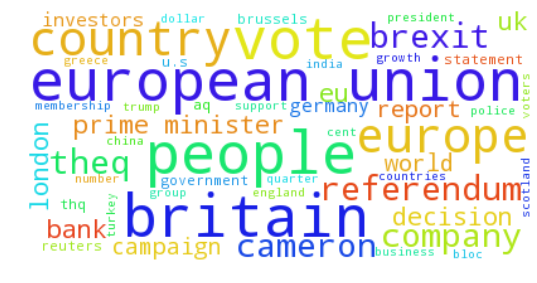

[(u'european union', 0.004961933057208647), (u'britain', 0.0049108856408430195), (u'people', 0.0031406370802027914), (u'vote', 0.002908362227545515), (u'country', 0.002808356585680164), (u'europe', 0.00253271693097469), (u'referendum', 0.0024344575722308453), (u'company', 0.0023472587260924428), (u'brexit', 0.0021914441770055446), (u'cameron', 0.002017983669805588), (u'theq', 0.0018742900109874885), (u'prime minister', 0.0018731477349705167), (u'eu', 0.0017243541786820184), (u'bank', 0.0016473736913276058), (u'london', 0.001625578612388738), (u'decision', 0.001454880818894492), (u'uk', 0.0014331892819211978), (u'report', 0.0013225930026976845), (u'world', 0.0013062437438112143), (u'campaign', 0.0012852620192993502), (u'investors', 0.0012838587635169588), (u'germany', 0.0012403806767891188), (u'government', 0.0012316844201447593), (u'u.s', 0.0011936456372601994), (u'reuters', 0.001131650695421978), (u'brussels', 0.0010916778282156223), (u'statement', 0.0010838945493831722), (u'aq', 0.00

In [128]:
draw_top_aspects_by_col(col='pagerank', top_n=50)

## Sentiment of the aspects 

In [153]:
def draw_top_aspects_by_sent(df=df_filtered, col='mean_sent', top_n=100, pagerank_min=0.00005, 
                             min_degree=None, sentiment='positive'):
    counts = []
    
    # only positive of negative sentiment
    if sentiment in ['positive']:
        df = df[df.mean_sent > 0]
    elif sentiment in ['negative']:
        df = df[df.mean_sent < 0]
        # the higher sentiemtn the bigger word, reverse sign 
        df.mean_sent = df.mean_sent.apply(lambda x: x * (-1))
    else:
        raise 'Wrong sentiment variable, should be positive or negative only'
    
#     df = df[df.degree > min_degree]
#     print df
    
    if min_degree is not None:
        df = df[df.degree > min_degree]
    
    for _, row in df[df.pagerank > pagerank_min].sort_values(['degree', col], ascending=False).head(top_n)[['aspect', col]].iterrows():
        counts.append((row['aspect'], row[col]))
    
    print counts
    draw_wordcloud(counts)

### Positive

[(u'european union', 0.7385272145144077), (u'country', 0.26884779516358465), (u'people', 0.09968847352024922), (u'europe', 0.4868035190615836), (u'reuters', 0.5497835497835498), (u'eu', 0.04121475054229935), (u'world', 0.5508021390374331), (u'prime minister', 0.08196721311475409), (u'bank', 0.6589861751152074), (u'decision', 0.6395348837209303), (u'uk', 0.4121212121212121), (u'germany', 0.6325301204819277), (u'government', 0.19480519480519481), (u'brussels', 0.47572815533980584), (u'membership', 0.34767025089605735), (u'france', 0.457286432160804), (u'scotland', 0.6581196581196581), (u'thousands', 0.631578947368421), (u'ireland', 0.6224489795918368), (u'man', 0.05732484076433121), (u'business', 0.11377245508982035), (u'growth', 0.2247191011235955), (u'new york', 0.5232558139534884), (u'india', 0.6463414634146342), (u'future', 0.7746478873239436), (u'economy', 0.06432748538011696), (u'city', 0.19424460431654678), (u'deal', 0.136986301369863), (u'life', 0.5798319327731093), (u'fears', 0.

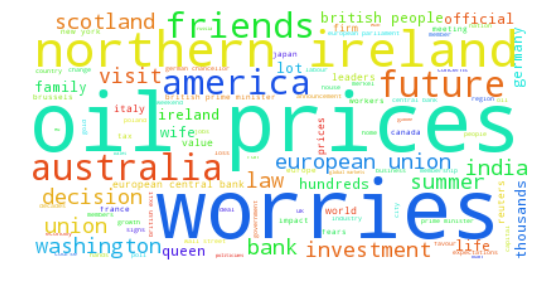

In [147]:
draw_top_aspects_by_sent(min_degree=100)

### Negative

[(u'britain', 0.09012875536480687), (u'vote', 0.6487179487179487), (u'referendum', 0.08870967741935484), (u'brexit', 0.19655172413793104), (u'cameron', 0.5225806451612903), (u'company', 0.793859649122807), (u'london', 0.2975391498881432), (u'investors', 0.041025641025641026), (u'u.s', 0.16111111111111112), (u'campaign', 0.8375350140056023), (u'england', 0.0037735849056603774), (u'report', 0.5303643724696356), (u'president', 0.5611814345991561), (u'dollar', 0.5165562913907285), (u'stocks', 0.6173913043478261), (u'number', 0.27835051546391754), (u'china', 0.5145631067961165), (u'voters', 0.14691943127962084), (u'statement', 0.7514792899408284), (u'support', 0.7204301075268817), (u'united kingdom', 0.20192307692307693), (u'morning', 0.4268292682926829), (u'way', 0.3333333333333333), (u'quarter', 0.6521739130434783), (u'united states', 0.6477987421383647), (u'money', 0.6470588235294118), (u'result', 0.8987341772151899), (u'bloc', 0.21142857142857144), (u'brexit vote', 0.6140350877192983), 

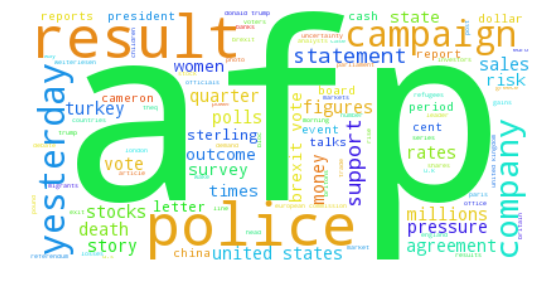

In [154]:
draw_top_aspects_by_sent(sentiment='negative')